In [287]:
from pandas import Series
import pandas as pd
from pandas import concat
import numpy as np
import seaborn as sns
from collections import Counter
import calendar
import json
import sys
from numpy import mean
from numpy import std
import pylab as pl
from numpy import hstack
import math
import random
import os
import csv

from statsmodels.tsa.ar_model import AR
import re
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from scipy.stats import t
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF
import xgboost as xgb

import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.ticker as mtick
from matplotlib.ticker import PercentFormatter
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles

from fast_ml.feature_selection import get_constant_features
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
import sklearn.cluster
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import VarianceThreshold
from sklearn import svm
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.utils import resample

from feature_engine.outliers import OutlierTrimmer
from feature_engine.encoding import OneHotEncoder

from sklearn.metrics import recall_score,accuracy_score,confusion_matrix, f1_score, precision_score, \
    auc,roc_auc_score,roc_curve, precision_recall_curve, log_loss
from sklearn.metrics import mean_squared_error

import datetime as dt
from datetime import datetime, date, timedelta

import shap 
shap.initjs()

%matplotlib inline
plt.style.use('ggplot')


## Table of Contents

* [1. Importing Data and Initial Glance](#1)
* [2. EDA](#2)
    - [2.1 : sales_train Dataset](#3)
    - [2.2 : shops Dataset](#4)
    - [2.3 : items_cat Dataset](#5)   
* [3. Data aggregation](#6)
    - [3.1 : Monthly count](#7)
    - [3.2 : sales_test Dataset and Consistency](#8)
    - [3.3 : Further Manupulation](#9)  



<a id="1"></a>
## 1. Importing Data and Initial Glance

Data fields
    
* ID - an Id that represents a (Shop, Item) tuple within the test set
* shop_id - unique identifier of a shop
* item_id - unique identifier of a product
* item_category_id - unique identifier of item category
* item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
* item_price - current price of an item
* date - date in format dd/mm/yyyy
* date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
* item_name - name of item
* shop_name - name of shop
* item_category_name - name of item category

In [132]:
sales_train = pd.read_csv('competitive-data-science-predict-future-sales/sales_train.csv')
shops = pd.read_csv('competitive-data-science-predict-future-sales/shops.csv')
items = pd.read_csv('competitive-data-science-predict-future-sales/items.csv')
items_cat = pd.read_csv('competitive-data-science-predict-future-sales/item_categories.csv')
sales_test= pd.read_csv('competitive-data-science-predict-future-sales/test.csv')

In [133]:
sales_train.dtypes

date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object

In [134]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [135]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [136]:
items_cat.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [137]:
sales_test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [138]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


<a id="2"></a>
## 2. EDA & Feature Engineering


The EDA and Feature Engineering includes 4 parts 
* I. Null and Duplicates
* II. Outlier 
* III. Distribution Check
* IV. Feature Engineering



Given the time constraint, for Task 1, we will provide a multi-variate table prepared for future exploration. For Task 2, we will only use univariate time-series to train the LSTM model. 

<a id="3"></a>
#### 2.1 sales_train Dataset

In [139]:
print("-------Missing Values----------")
print(sales_train.isnull().sum())
print("-------NULL values-------------")
print(sales_train.isna().sum())

-------Missing Values----------
date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64
-------NULL values-------------
date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64


In [140]:
## Convert to datetime and include monthly variables for future seasonality check

sales_train["date"] = pd.to_datetime(sales_train["date"], format="%d.%m.%Y")
sales_train["month"] = pd.to_datetime(sales_train["date"]).dt.month_name()
sales_train["year"] = pd.to_datetime(sales_train["date"]).dt.year
sales_train.drop(sales_train[sales_train.item_price <0].index, inplace=True) 
# guess: item_price should not be negative, thus omitted until further clarification
sales_train.drop(sales_train[sales_train.item_cnt_day <0].index, inplace=True) 
# guess: item_cnt may negative (stands for returns), omitted until further clarification

In [141]:
## For sales_train dataset, even though there are duplicates like below, 
## at this stage, it is difficult to determine whether these are 'true' duplicates
## need further confirmation of data source
sales_train[sales_train.duplicated(keep=False)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month,year
76961,2013-01-05,0,54,20130,149.0,1.0,January,2013
76962,2013-01-05,0,54,20130,149.0,1.0,January,2013
1435365,2014-02-23,13,50,3423,999.0,1.0,February,2014
1435367,2014-02-23,13,50,3423,999.0,1.0,February,2014
1496765,2014-03-23,14,21,3423,999.0,1.0,March,2014
1496766,2014-03-23,14,21,3423,999.0,1.0,March,2014
1671872,2014-05-01,16,50,3423,999.0,1.0,May,2014
1671873,2014-05-01,16,50,3423,999.0,1.0,May,2014
1866322,2014-07-12,18,25,3423,999.0,1.0,July,2014
1866340,2014-07-12,18,25,3423,999.0,1.0,July,2014


* We mainly focus on the Outlier for sales_train dataset. 
* The two numerical features are item_price and item_cnt_day. 
* We use Gaussian Outlier Trimmer

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:xlabel='item_price'>

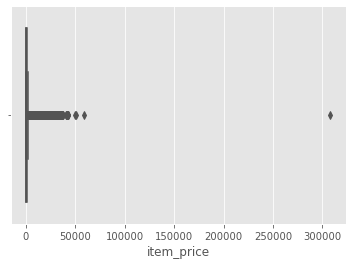

In [142]:
sns.boxplot(sales_train['item_price'])

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:xlabel='item_cnt_day'>

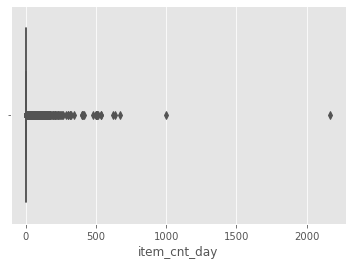

In [143]:
sns.boxplot(sales_train['item_cnt_day'])

In [155]:
trimmer = OutlierTrimmer(capping_method='gaussian',
                         tail='right', fold=3, variables=['item_price', 'item_cnt_day'])

trimmer.fit(sales_train)

OutlierTrimmer(variables=['item_price', 'item_cnt_day'])

In [156]:
trimmer.right_tail_caps_

{'item_price': 6071.962498002507, 'item_cnt_day': 9.10709546406408}

In [157]:
sales_train_after = trimmer.transform(sales_train)

In [158]:
sales_train_after.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,date_block_num,shop_id,item_id,item_price,item_cnt_day,year
count,2.88823e+06,2.88823e+06,2.88823e+06,2.88823e+06,2.88823e+06,2.88823e+06
mean,14.546,33.0186,10189.8,752.513,1.16547,2013.78
std,9.42927,16.2267,6335.85,810.509,0.649847,0.768818
min,0,0,0,0.07,1,2013
25%,6,22,4424,249,1,2013
50%,14,31,9336,399,1,2014
75%,23,47,15729,991,1,2014
max,33,59,22169,6040,9,2015


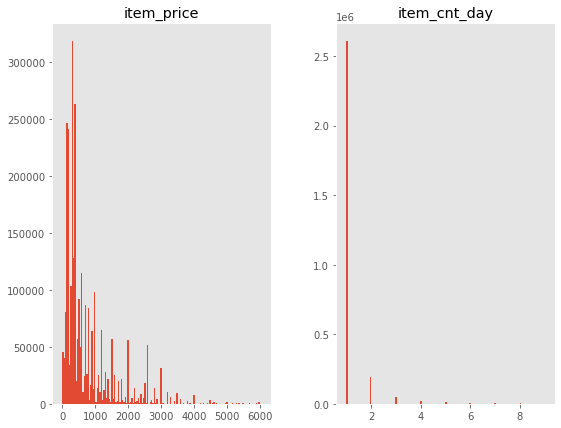

In [159]:
sales_train_after[['item_price','item_cnt_day']].hist(bins=150,figsize=(9,7),grid=False);

In [301]:
sales_train_after['month'] = pd.Categorical(sales_train_after['month'], ordered=True, 
                                      categories= ['January', 'February', 'March', 'April','May',
                                                   'June', 'July', 'August','September', 
                                                   'October', 'November', 'December'])
pv_trial = pd.pivot_table(sales_train_after, index=sales_train_after.month, columns=sales_train_after.year,
                    values='item_cnt_day', aggfunc='sum')

<AxesSubplot:xlabel='month'>

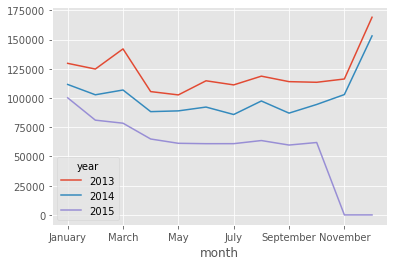

In [302]:
pv_trial.plot()

In [303]:
pv_trial_shop = pd.pivot_table(sales_train_after[sales_train_after['shop_id']==22], index=sales_train_after.month, columns=sales_train_after.year,
                    values='item_cnt_day', aggfunc='sum')

<AxesSubplot:xlabel='month'>

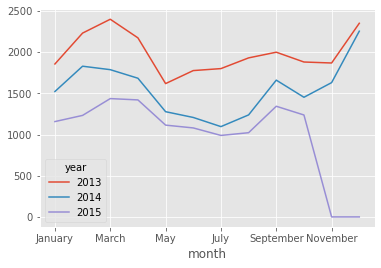

In [304]:
pv_trial_shop.plot()

* Conclusion: yearly stationary, overall decreasing, strong seasonality, seasonality exists within store

<a id="4"></a>
#### 2.2 shops Dataset

In [160]:
## For shops dataset, we split the information into 3 categories, city, shop_brand, shop_category
print("-------Missing Values----------")
print(shops.isnull().sum())
print("-------NULL values-------------")
print(shops.isna().sum())

-------Missing Values----------
shop_name    0
shop_id      0
dtype: int64
-------NULL values-------------
shop_name    0
shop_id      0
dtype: int64


In [161]:
shops["city"] = shops.shop_name.str.split(" ").map(lambda x: x[0])

In [162]:
list = [] 
for i in range(len(shops)):
    if not re.findall('"([^"]*)"', shops['shop_name'][i]):
        list.append('other')
    else:
        list.append(re.findall('"([^"]*)"', shops['shop_name'][i])[0])
shops['shop_brand'] = list # extract shop brand information from the quotations 

In [163]:
def name_correction(x):
    x = x.lower() # all letters lower case
    x = re.sub('[^A-Za-z0-9А-Яа-я]+', ' ', x) # remove special characters
    x = x.replace('  ', ' ') # replace double spaces with single spaces
    x = x.strip() # remove leading and trailing white space
    return x

In [164]:
shops["shop_name"] = shops["shop_name"].apply(lambda x: name_correction(x))

In [165]:
shops["shop_category"] = shops.shop_name.str.split(" ").map(lambda x: x[1])

In [166]:
shops[shops["shop_name"].duplicated(keep=False)]

,shop_name,shop_id,city,shop_brand,shop_category
10,жуковский ул чкалова 39м,10,Жуковский,other,ул
11,жуковский ул чкалова 39м,11,Жуковский,other,ул


In [167]:
shops.drop(11, axis=0, inplace=True)

In [185]:
sales_train_after.loc[sales_train_after.shop_id==11, 'shop_id']=10
sales_test.loc[sales_test.shop_id==11, 'shop_id']=10

In [170]:
shops['shop_category'].value_counts()

тц              27
трц              9
трк              5
тк               5
орджоникидзе     2
магазин          2
новгород         2
плехановская     1
торговля         1
ул               1
распродажа       1
мтрц             1
посад            1
склад            1
Name: shop_category, dtype: int64

In [171]:
def sub_category(x): 
    if len(shops[shops['shop_category']==x]) >= 5:
        return x
    else:
        return 'other'

In [172]:
shops.shop_category = shops.shop_category.apply(sub_category) 
# only keep shop_category with sufficient frequency 

In [173]:
shops.head()

,shop_name,shop_id,city,shop_brand,shop_category
0,якутск орджоникидзе 56 фран,0,!Якутск,other,other
1,якутск тц центральный фран,1,!Якутск,Центральный,тц
2,адыгея тц мега,2,Адыгея,Мега,тц
3,балашиха трк октябрь киномир,3,Балашиха,Октябрь-Киномир,трк
4,волжский тц волга молл,4,Волжский,Волга Молл,тц


<a id="5"></a>
#### 2.3 items_cat Dataset

In [174]:
## For items dataset
print("-------Missing Values----------")
print(items_cat.isnull().sum())
print("-------NULL values-------------")
print(items_cat.isna().sum())

-------Missing Values----------
item_category_name    0
item_category_id      0
dtype: int64
-------NULL values-------------
item_category_name    0
item_category_id      0
dtype: int64


In [175]:
items_cat['category'] = items_cat['item_category_name'].apply(lambda x: x.split()[0])

In [176]:
items_cat['category'].value_counts()

Игры          14
Книги         13
Подарки       12
Игровые        8
Аксессуары     7
Музыка         6
Программы      6
Карты          5
Кино           5
Служебные      2
Чистые         2
PC             1
Билеты         1
Доставка       1
Элементы       1
Name: category, dtype: int64

In [177]:
def sub_category_items(x): 
    if len(items_cat[items_cat['category']==x]) >= 5:
        return x
    else:
        return 'other'

In [179]:
items_cat.category = items_cat.category.apply(sub_category_items) 
# only keep item_category with sufficient frequency 

In [180]:
items_cat.head()

,item_category_name,item_category_id,category
0,PC - Гарнитуры/Наушники,0,other
1,Аксессуары - PS2,1,Аксессуары
2,Аксессуары - PS3,2,Аксессуары
3,Аксессуары - PS4,3,Аксессуары
4,Аксессуары - PSP,4,Аксессуары


<a id="6"></a>
## 3. Data Aggregation

We first join the dataframes together, such that in the future we can further investigate multi-variate models. 

In [186]:
train = sales_train_after.join(items, on='item_id', 
                   rsuffix='_').join(shops, on='shop_id'
                   , rsuffix='_').join(items_cat, on='item_category_id'
                   , rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)

In [182]:
train.head().T

,0,1,3,4,5
date,2013-01-02 00:00:00,2013-01-03 00:00:00,2013-01-06 00:00:00,2013-01-15 00:00:00,2013-01-10 00:00:00
date_block_num,0,0,0,0,0
shop_id,59,25,25,25,25
item_id,22154,2552,2554,2555,2564
item_price,999.0,899.0,1709.05,1099.0,349.0
item_cnt_day,1.0,1.0,1.0,1.0,1.0
month,January,January,January,January,January
year,2013,2013,2013,2013,2013
item_name,ЯВЛЕНИЕ 2012 (BD),DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE Who Do You Think We Are LP,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),DEEP PURPLE Perihelion: Live In Concert DVD (К...
item_category_id,37,58,58,56,59


In [188]:
# if needed, we can further transform the training data using OneHotEncoder. 
ohe_enc = OneHotEncoder(top_categories=None,
                        variables=['category', 'shop_category', 'city'],
                        drop_last=False)
ohe_enc.fit(train)

OneHotEncoder(variables=['category', 'shop_category', 'city'])

In [189]:
train_ohe = ohe_enc.transform(train)

In [191]:
train['sales_income'] = train['item_price'] * train['item_cnt_day']

<a id="7"></a>
#### 3.1 Monthly Count

We first experiment with monthly sales_income

In [196]:

monthly_sales_income = train.groupby(['date_block_num'])['sales_income'].sum()
df_monthly_sales_income= pd.DataFrame(monthly_sales_income)

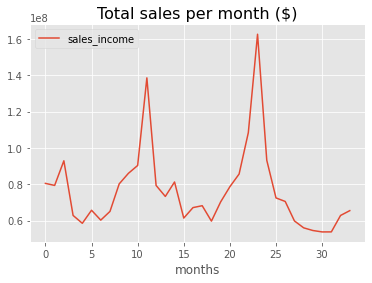

In [197]:
df_monthly_sales_income.plot()
plt.title("Total sales per month ($)", fontsize = 16)
plt.xlabel("months");

In [198]:
train['month'] = pd.Categorical(train['month'], ordered=True, 
                                      categories= ['January', 'February', 'March', 
                                                   'April','May','June', 'July', 'August','September', 
                                                   'October', 'November', 'December'])
pv = pd.pivot_table(train, index=train.month, columns=train.year,
                    values='sales_income', aggfunc='sum')

<AxesSubplot:xlabel='month'>

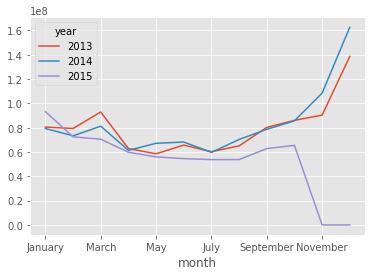

In [199]:
pv.plot()

In [203]:
# Example of monthly sales_income for specific sub-category
# Can be used for future exploration
pv_shop_category_тк = pd.pivot_table(train[train['shop_category']== 'тк'], 
                                     index=train.month, columns=train.year,
                    values='sales_income', aggfunc='sum')

<AxesSubplot:xlabel='month'>

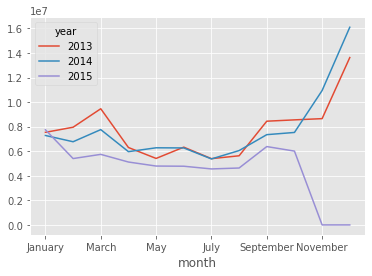

In [202]:
pv_shop_category_тк.plot()

In [205]:
pv_category_Карты = pd.pivot_table(train[train['category']=='Карты'], 
                                   index=train.month, columns=train.year,
                    values='sales_income', aggfunc='sum')

<AxesSubplot:xlabel='month'>

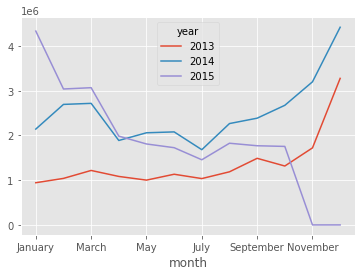

In [206]:
pv_category_Карты.plot()

Next we turn to the target variable for this project: Monthly cnt 

In [207]:
pv_cnt = pd.pivot_table(train, index=train.month, columns=train.year,
                    values='item_cnt_day', aggfunc='sum')

<AxesSubplot:xlabel='month'>

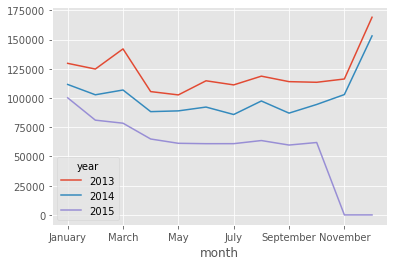

In [208]:
pv_cnt.plot()

<a id="8"></a>
#### 3.2 sales_test Dataset and Consistency

In [209]:
sales_test = pd.merge(sales_test , items[['item_id','item_category_id']], how="inner");
sales_test  = pd.merge(sales_test , shops[['shop_id','city', 'shop_brand', 'shop_category' ]], how="inner");
sales_test  = pd.merge(sales_test , items_cat[['item_category_id','category' ]], how="inner");

In [211]:
sales_test

,ID,shop_id,item_id,item_category_id,city,shop_brand,shop_category,category
0,0,5,5037,19,Вологда,Мармелад,трц,Игры
1,2,5,5233,19,Вологда,Мармелад,трц,Игры
2,15,5,4872,19,Вологда,Мармелад,трц,Игры
3,21,5,5002,19,Вологда,Мармелад,трц,Игры
4,23,5,5814,19,Вологда,Мармелад,трц,Игры
...,...,...,...,...,...,...,...,...
214195,213658,45,342,44,Самара,ПаркХаус,тц,Книги
214196,213659,45,254,44,Самара,ПаркХаус,тц,Книги
214197,213660,45,204,44,Самара,ПаркХаус,тц,Книги
214198,213661,45,180,44,Самара,ПаркХаус,тц,Книги


* Note that for sales_test data, we only have certain subset of shop_id and item_id. 
* Therefore we can 1: only use the shop_id and item_id that exists in test set for training, or 2: train the entire model but only compare the result for these shop_id. 
* We are using the first option: assuming that we have complete information for Nov on these shop_id

In [224]:
test_shop_ids = sales_test['shop_id'].unique()
test_item_ids = sales_test['item_id'].unique()
# Only shops that exist in test set.
train_consis = train[train['shop_id'].isin(test_shop_ids)]
# Only items that exist in test set.
train_consis = train_consis[train_consis['item_id'].isin(test_item_ids)]

In [246]:
train_monthly = train_consis[['date', 'date_block_num', 'shop_id', 'item_id', 'item_cnt_day']]
train_monthly = train_monthly.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False)
train_monthly = train_monthly.agg({'item_cnt_day':['sum']})
train_monthly.columns = ['date_block_num', 'shop_id', 'item_id', 'item_cnt']
train_monthly = train_monthly.query('item_cnt >= 0 and item_cnt <= 20')
# Label
train_monthly['item_cnt_month'] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)

In [252]:
final_train = train_monthly.pivot_table(index = ['shop_id','item_id']
                                     ,values = 'item_cnt' ,columns = ['date_block_num'],fill_value = 0,aggfunc='sum') .reset_index()

In [256]:
final_train.head()

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,2,30,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,31,0,4,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2,32,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
3,2,33,1,0,0,0,0,0,0,0,...,0,1,0,1,1,0,1,0,1,0
4,2,53,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [257]:
test = pd.pivot_table(sales_test, index = [sales_test.shop_id, sales_test.item_id],values = 'ID', aggfunc = 'count', fill_value = 0).reset_index()

In [274]:
test

,shop_id,item_id,ID
0,2,30,1
1,2,31,1
2,2,32,1
3,2,33,1
4,2,38,1
...,...,...,...
214195,59,22162,1
214196,59,22163,1
214197,59,22164,1
214198,59,22166,1


In [265]:
combine_train_test =  pd.merge(final_train, test, how = 'left', on = ['shop_id','item_id']).fillna(0)

<a id="9"></a>
#### 3.3 Further Manipulation 

In [266]:
combine_train_test

,shop_id,item_id,0,1,2,3,4,5,6,7,...,25,26,27,28,29,30,31,32,33,ID
0,2,30,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2,31,0,4,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,2,32,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1
3,2,33,1,0,0,0,0,0,0,0,...,1,0,1,1,0,1,0,1,0,1
4,2,53,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110262,59,22145,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
110263,59,22154,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
110264,59,22162,0,0,0,0,0,0,0,0,...,9,4,1,1,0,0,1,0,0,1
110265,59,22164,0,0,0,0,0,0,0,0,...,2,1,2,0,0,1,0,0,0,1


In [272]:
total = final_train.iloc[:, 2:].sum(axis = 0) 
# sum up all the monthly cnt across the stores in sales_test

<AxesSubplot:xlabel='date_block_num'>

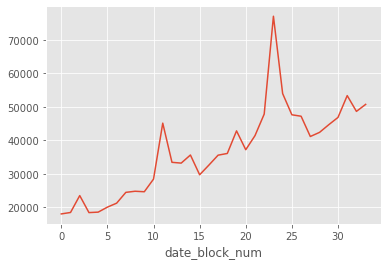

In [275]:
total.plot()

In [285]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = pd.DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

In [281]:
# since the series is not stationary
def difference(dataset, interval=1):
	diff = []
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

In [288]:
diff_values = difference(total, 1)
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

<AxesSubplot:>

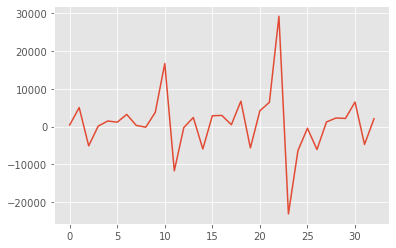

In [291]:
diff_values.plot()

In [269]:
p = pd.DataFrame(columns=final_train.columns, index=[final_train.index.name]).append(final_train)
p.to_csv('train.csv',index_label=final_train.columns.name)

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
